In [ ]:
#CREDITS
#THANKS TURKUNLP for releasing FinBERT models, this tutorial wouldn't be possible without those models.
#TurkuNLP Github repo can be found here: https://github.com/TurkuNLP/FinBERT

In [2]:
#install awscli so we can fetch files from public repositories (I share files for this demo in that way)
!pip install awscli

In [3]:
#download requirements.txt 
!aws s3 --no-sign-request cp s3://ml-examples-data-and-modelfileshare/models/finbert/requirements.txt requirements.txt

download: s3://ml-examples-data-and-modelfileshare/models/finbert/requirements.txt to ./requirements.txt


In [4]:
#install dependencies with requirements.txt 
# RESTART RUNTIME AFTER INSTALLATION AND MAKE SURE YOU ARE USING GPU ACCELERATED RUNTIME!
!pip install -r requirements.txt

     |████████████████████████████████| 317kB 6.5MB/s 
     |████████████████████████████████| 102kB 7.5MB/s 
     |████████████████████████████████| 20.2MB 1.2MB/s 
     |████████████████████████████████| 10.4MB 50.6MB/s 
     |████████████████████████████████| 6.7MB 58.6MB/s 
     |████████████████████████████████| 380.8MB 46kB/s 
     |████████████████████████████████| 3.3MB 45.7MB/s 
     |████████████████████████████████| 51kB 8.4MB/s 
     |████████████████████████████████| 983kB 46.5MB/s 
     |████████████████████████████████| 245kB 52.9MB/s 
     |████████████████████████████████| 1.8MB 48.2MB/s 
     |████████████████████████████████| 778kB 47.0MB/s 
     |████████████████████████████████| 3.8MB 48.4MB/s 
     |████████████████████████████████| 450kB 27.0MB/s 
     |████████████████████████████████| 6.5MB 42.8MB/s 
     |████████████████████████████████| 3.0MB 50.8MB/s 
     |████████████████████████████████| 1.1MB 48.5MB/s 
     |████████████████████████████████| 890kB 46.5M

In [1]:
import ktrain
from ktrain import text
import pandas as pd

using Keras version: 2.2.4-tf


In [2]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline
import os
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID";
os.environ["CUDA_VISIBLE_DEVICES"]="0"; 

In [3]:
#download data
!mkdir data
!aws s3 --no-sign-request cp s3://ml-examples-data-and-modelfileshare/data/all_preprocessed_filtered.csv data/all_preprocessed_filtered.csv 

download: s3://ml-examples-data-and-modelfileshare/data/all_preprocessed_filtered.csv to data/all_preprocessed_filtered.csv


In [5]:
df = pd.read_csv('data/all_preprocessed_filtered.csv').drop_duplicates()

In [6]:
df.label.value_counts()

__label__Yhteiskunta              10220
__label__Terveys                   6142
__label__Suhteet                   5995
__label__Perhe                     4804
__label__Talous                    4776
__label__Matkailu                  4166
__label__Työ ja opiskelu           3476
__label__Lemmikit                  3299
__label__Koti ja rakentaminen      2874
__label__Viihde ja kulttuuri       2723
__label__Paikkakunnat              2615
__label__Urheilu ja kuntoilu       2159
__label__Ryhmät                    2118
__label__Ajanviete                 2102
__label__Nuoret                    2097
__label__Tiede ja teknologia       2027
__label__Ajoneuvot ja liikenne     2024
__label__Ruoka ja juoma            2017
Name: label, dtype: int64

In [7]:
# Select few classes that you want or all. I have here chosen 5 classes to keep
labels_to_keep = ['__label__Terveys', '__label__Talous','__label__Lemmikit','__label__Urheilu ja kuntoilu','__label__Matkailu']

# This will filter out classes not chosen 
df = df[df.label.isin(labels_to_keep)]



In [8]:
# These 2 lines will take sample from each class(label) according to the size of the smalles. 
#Thus it will balance dataset. You might want to use some other techique to mitigate possibility of class imbalance but this is what I've used here and it seems to work ok.
g = df.groupby('label')
df = pd.DataFrame(g.apply(lambda x: x.sample(g.size().min()).reset_index(drop=True)))

In [9]:
# Drop empty ones if there are any left just in case
df['text_and_title'] = df['text_and_title'].dropna()

In [10]:
#Drop unneeded columns
df = df[['label','text_and_title']]

In [11]:
#lets look how dataframe looks
df.head()

label                                     text_and_title
label                                                                                    
__label__Lemmikit 0  __label__Lemmikit  Amstaffit ja Pittbullit.Paska,puhdetta,sanon,m...
                  1  __label__Lemmikit  Kaduttaako koskaan?.Onko,kissa,sopiva,kerrosta...
                  2  __label__Lemmikit  Isojen koirien omistus kriminalisoitava, HETI ...
                  3  __label__Lemmikit  Oletteko.Käyttäneet,ravitsemusneuvojan,apuja,o...
                  4  __label__Lemmikit  Hyvästi Anton "Reiska".Mitä,väliä,kuka,harrast...

In [12]:
#There seems to be unnecessary label column as index column, lets get rid of it
df.reset_index(drop=True, inplace=True)

In [13]:
# Lets check that it is gone
df.head()

,label,text_and_title
0,__label__Lemmikit,"Amstaffit ja Pittbullit.Paska,puhdetta,sanon,m..."
1,__label__Lemmikit,"Kaduttaako koskaan?.Onko,kissa,sopiva,kerrosta..."
2,__label__Lemmikit,"Isojen koirien omistus kriminalisoitava, HETI ..."
3,__label__Lemmikit,"Oletteko.Käyttäneet,ravitsemusneuvojan,apuja,o..."
4,__label__Lemmikit,"Hyvästi Anton ""Reiska"".Mitä,väliä,kuka,harrast..."


In [14]:
#Transform dataframe to the shape needed by ktrain/BERT.
df = pd.concat([df, df.label.astype('str').str.get_dummies()], axis=1, sort=False)

In [15]:
#Lets check that data was transformed correctly
df.head()

,label,text_and_title,__label__Lemmikit,__label__Matkailu,__label__Talous,__label__Terveys,__label__Urheilu ja kuntoilu
0,__label__Lemmikit,"Amstaffit ja Pittbullit.Paska,puhdetta,sanon,m...",1,0,0,0,0
1,__label__Lemmikit,"Kaduttaako koskaan?.Onko,kissa,sopiva,kerrosta...",1,0,0,0,0
2,__label__Lemmikit,"Isojen koirien omistus kriminalisoitava, HETI ...",1,0,0,0,0
3,__label__Lemmikit,"Oletteko.Käyttäneet,ravitsemusneuvojan,apuja,o...",1,0,0,0,0
4,__label__Lemmikit,"Hyvästi Anton ""Reiska"".Mitä,väliä,kuka,harrast...",1,0,0,0,0


In [16]:
# Now that we have transformed the label column to correct dimensionality we don't need the original column anymore
df = df.drop(columns=('label'))

In [17]:
#Lets check that label column is now gone
df.head()

,text_and_title,__label__Lemmikit,__label__Matkailu,__label__Talous,__label__Terveys,__label__Urheilu ja kuntoilu
0,"Amstaffit ja Pittbullit.Paska,puhdetta,sanon,m...",1,0,0,0,0
1,"Kaduttaako koskaan?.Onko,kissa,sopiva,kerrosta...",1,0,0,0,0
2,"Isojen koirien omistus kriminalisoitava, HETI ...",1,0,0,0,0
3,"Oletteko.Käyttäneet,ravitsemusneuvojan,apuja,o...",1,0,0,0,0
4,"Hyvästi Anton ""Reiska"".Mitä,väliä,kuka,harrast...",1,0,0,0,0


In [18]:
# Lets defile list of label columns. We will use this later in the preprocessing step
label_columns = [i for i in df.columns[1:]]

In [19]:
# Download model files and place those to the folder that ktrain by default will use. Normally ktrain uses language detection to detect which model to download. Detecting finnish defaults to downloading multilingual model but we wan't to use finnish model.
# Thus placing the model in default directory with the name of the multilingual model will make it so that ktrain won't download the multilingual model and instead will use finnish model that is now just named as multilingual model (This is a trick to fool ktrain)
!rmdir  /root/ktrain_data/multi_cased_L-12_H-768_A-12
!mkdir /root/ktrain_data
!aws s3 cp --no-sign-request --recursive s3://ml-examples-data-and-modelfileshare/models/finbert/multi_cased_L-12_H-768_A-12 /root/ktrain_data/multi_cased_L-12_H-768_A-12

rmdir: failed to remove '/root/ktrain_data/multi_cased_L-12_H-768_A-12': No such file or directory
download: s3://ml-examples-data-and-modelfileshare/models/finbert/multi_cased_L-12_H-768_A-12/bert_config.json to ../root/ktrain_data/multi_cased_L-12_H-768_A-12/bert_config.json
download: s3://ml-examples-data-and-modelfileshare/models/finbert/multi_cased_L-12_H-768_A-12/bert_model.ckpt.index to ../root/ktrain_data/multi_cased_L-12_H-768_A-12/bert_model.ckpt.index
download: s3://ml-examples-data-and-modelfileshare/models/finbert/multi_cased_L-12_H-768_A-12/vocab.txt to ../root/ktrain_data/multi_cased_L-12_H-768_A-12/vocab.txt
download: s3://ml-examples-data-and-modelfileshare/models/finbert/multi_cased_L-12_H-768_A-12/bert_model.ckpt.meta to ../root/ktrain_data/multi_cased_L-12_H-768_A-12/bert_model.ckpt.meta
download: s3://ml-examples-data-and-modelfileshare/models/finbert/multi_cased_L-12_H-768_A-12/bert_model.ckpt.data-00000-of-00001 to ../root/ktrain_data/multi_cased_L-12_H-768_A-12/

In [20]:
(x_train, y_train), (x_test, y_test), preproc = text.texts_from_df(df, 
                                                                   'text_and_title', # name of column containing review text
                                                                   label_columns=label_columns,
                                                                   maxlen=100, 
                                                                   max_features=100000,
                                                                   preprocess_mode='bert',
                                                                   val_pct=0.2)

preprocessing train...
language: fi


preprocessing test...
language: fi


In [21]:
# lets define the model and learner objects
model = text.text_classifier('bert', (x_train, y_train) , preproc=preproc)
learner = ktrain.get_learner(model, 
                             train_data=(x_train, y_train), 
                             val_data=(x_test, y_test), 
                             batch_size=16)

Is Multi-Label? False
maxlen is 100
done.


simulating training for different learning rates... this may take a few moments...
Train on 8636 samples
Epoch 1/1024
8636/8636 [==============================] - 414s 48ms/sample - loss: 1.1662 - accuracy: 0.5418
Epoch 2/1024
4480/8636 [==============>...............] - ETA: 3:08 - loss: 0.3818 - accuracy: 0.8862

done.
Please invoke the Learner.lr_plot() method to visually inspect the loss plot to help identify the maximal learning rate associated with falling loss.


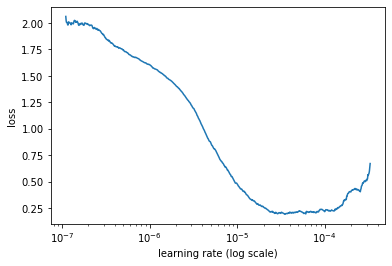

In [22]:
#Lets use learning rate finder to find good learning rate. Good starting learning rate is x/10 where x is the spot where loss vs learning rate curve starts to rise
learner.lr_find()
learner.lr_plot()

In [23]:
# Now lets run training using the onecycle method. Here we run just 1 epoch.
learner.fit_onecycle(7e-5, 1)



begin training using onecycle policy with max lr of 7e-05...
Train on 8636 samples, validate on 2159 samples
8636/8636 [==============================] - 418s 48ms/sample - loss: 0.3202 - accuracy: 0.8872 - val_loss: 0.0890 - val_accuracy: 0.9787


In [24]:
# Just after 1 epoch, lets see what kind of results we can get on test set.
learner.validate(val_data=(x_test, y_test), class_names=label_columns)

                              precision    recall  f1-score   support

           __label__Lemmikit       0.98      0.99      0.98       442
           __label__Matkailu       1.00      0.97      0.98       452
             __label__Talous       0.98      0.98      0.98       440
            __label__Terveys       0.97      0.98      0.98       419
__label__Urheilu ja kuntoilu       0.97      0.97      0.97       406

                    accuracy                           0.98      2159
                   macro avg       0.98      0.98      0.98      2159
                weighted avg       0.98      0.98      0.98      2159



array([[438,   0,   1,   1,   2],
       [  3, 438,   5,   1,   5],
       [  2,   0, 433,   3,   2],
       [  2,   2,   0, 411,   4],
       [  4,   0,   3,   6, 393]])

In [25]:
# Woah, 98% accuracy with just one epoch, lets now test it with dew predictions. First lets make predictor object
predictor = ktrain.get_predictor(learner.model, preproc)

In [37]:
## Now lets test the model with few examples
texts = ["Kissat on kivoja", # "Cats are nice"
         "Suomen talous on kuralla, hallitus vaihtoon!",  # "Finnish economy sucks, lets switch the goverment!"
         "Kuntosalilla käyminen on kivaa, tulee hiki pintaan ja mielikin virkistyy"] #"Going to the gym is nice, one gets sweaty and it also refreshes ones mind"

for i,text in enumerate(texts):
    print("{}: {}".format(i, text))
    prediction = predictor.predict(text)
    print("prediction is: " + prediction + '\n')

0: Kissat on kivoja


prediction is: __label__Lemmikit

1: Suomen talous on kuralla, hallitus vaihtoon!


prediction is: __label__Talous

2: Kuntosalilla käyminen on kivaa, tulee hiki pintaan ja mielikin virkistyy


prediction is: __label__Urheilu ja kuntoilu



In [39]:
# Model seems to work quite well, lets finally save it.
!mkdir model
predictor.save('model/suomi24_5_topic_model_FinBERT')